In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import glob


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df_info  = pd.read_csv('SPindex.csv')
df_info = df_info.set_index('Symbol')
df_info.head()

,Security,GICS Sector,GICS Sub Industry,CIK
Symbol,,,,
MMM,3M Company,Industrials,Industrial Conglomerates,66740
ABT,Abbott Laboratories,Health Care,Health Care Equipment,1800
ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,1551152
ABMD,ABIOMED Inc,Health Care,Health Care Equipment,815094
ACN,Accenture plc,Information Technology,IT Consulting & Other Services,1467373


In [3]:
def check_file_existance(file_ids , tmpl):
    files = []
    path = tmpl.format(subject = '*')
    directory_files = glob.glob(path , recursive=True)

    for f_name in file_ids:
        filename = tmpl.format(subject = f_name)
        if filename in directory_files:
            files.append((f_name , filename))
        else:
            files.append((f_name , 'None'))
    return files


## Load Data From Files

In [4]:
def loadData(files , from_date , to_date):
    total  =  []
    
    for i in range(len(files)):
        file_id = files[i][0]
        filename = files[i][1]

        df = pd.read_csv(filename)
        df = df.loc[ (df['Date'] >= from_date) & (df['Date'] <= to_date)]
        
        df.dropna(inplace = True)
        
        #check for range
        max_date = df['Date'].max()
        min_date = df['Date'].min()

        if ( max_date == to_date and min_date == from_date ) :        
            df.insert(0,'Symbol',file_id)
            total.append(df)
    
    return total

In [5]:
from_date = '2019-01-02'
to_date = '2020-03-31'
symbol_names = list(df_info.index)
files = check_file_existance(symbol_names , 'stocks\{subject}.csv')
total = loadData(files , from_date ,  to_date)
total2 = total

## Clean Data and Create Total File

In [6]:
def clean_Data (ls_files):
    result = []
    for df in ls_files:
        df.dropna(inplace = True) 
        df['Close_Rolling'] = df['Adj Close'].rolling(5).mean()
        df['Close1']  = df['Adj Close'].shift()
        df['Change'] = (df['Adj Close'] - df.Close1)        
        df['ChangePercent'] = df.Change * 100 /  df['Adj Close']    
        df['Profit'] =  df.Change.cumsum()
        df['Range'] = (df.High - df.Low)
                
        new_df = df[['Symbol', 'Date', 'Close_Rolling','Profit','Range','ChangePercent', 'Volume']].copy()
        new_df.dropna(inplace = True)
        result.append(new_df)
        
        
    dataset = pd.concat(result)
    return dataset

In [7]:
data = clean_Data(total)
data.columns= ['Symbol', 'Date', 'Close_Rolling','Profit','Range','ChangePercent', 'Volume']
data.to_csv('stocks/total_clean.csv')
data.tail()

,Symbol,Date,Close_Rolling,Profit,Range,ChangePercent,Volume
1798,ZTS,2020-03-25,101.415909,24.346748,12.470001,4.112373,4424800.0
1799,ZTS,2020-03-26,104.526875,34.031082,9.180000,8.226616,4159000.0
1800,ZTS,2020-03-27,106.689374,27.900993,6.739998,-5.493431,2870100.0
1801,ZTS,2020-03-30,111.485612,32.803070,5.320000,4.208098,2031900.0
1802,ZTS,2020-03-31,114.267113,33.811440,6.349998,0.858188,3956000.0


In [8]:
for i in range(len(files)):
    if files[i][0] == 'AAPL':
        print(i)

47


In [1]:
total[47]

NameError: name 'total' is not defined

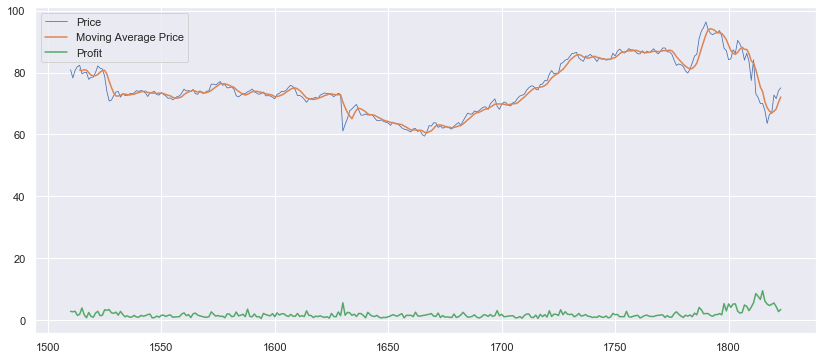

In [10]:
sns.set(rc={'figure.figsize':(14, 6)})
total[2]['Adj Close'].plot(linewidth=0.8, label = 'Price')
total[2]['Close_Rolling'].plot(linewidth=1.5 , label = 'Moving Average Price')
total[2]['Range'].plot(linewidth=1.5, label = 'Profit')
plt.legend()
plt.show()
#total[0]['Volume'].plot(linewidth=1)